First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here. This has to be done in several steps, else there is a memory error.

In [8]:
import pandas as pd
from math import radians, sin, cos

train_path = '../data/train3.pkl'
test_path = '../data/test3.pkl'

def equirectangular_projection(data):
    phi = data.lat.apply(radians)
    lamb = data.lon.apply(radians)
    lamb0 = lamb.mean()
    phi0 = phi.mean()
    r = 6378000  # earth radius in m
    x = r*(phi-phi0)
    y = r*(lamb - lamb0)*cos(phi0)
    return x, y

def compute_velocity(row):
    
    r = row.speed
    theta = radians(row.direction)
    row['dx'] = r*cos(radians(theta))
    row['dy'] = r*sin(radians(theta))
    return row

def filter_position_observed_events(data):
    return data[data.event == 'ObservedPositionEvent']

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    
    # Remove unnecessary fields
    del data['vehicle_id']
    del data['line']
    del data['station']
        
    data = filter_position_observed_events(data)
    
    del data['event']
    
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    
    x, y = equirectangular_projection(data)
    data['x'] = x
    data['y'] = y
    
    del data['lat']
    del data['lon']

    data = data.apply(compute_velocity, axis=1)
    
    del data['direction']
    del data['speed']
    
    data.to_pickle(to_path)
    
repackage('../data/203_train.p', train_path)
repackage('../data/203_test.p', test_path)

KeyboardInterrupt: 

In [14]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-02-16 03:48:40
2018-02-16 03:48:42.800000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752922800000000
dtype: object

## Load training data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, TrajectoryModel, predict
from pandas import DataFrame

np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 20 # len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ns = trajs.traj.unique()
def load_seg(traj_n, seg_n):
    return trajs[(trajs.traj == traj_n) & (trajs.seg == seg_n)]

## Learn normalisation functions for each segment
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [2]:
from math import sqrt
seg_dict = dict(tuple(data.groupby('seg')))
def normalisation(seg: DataFrame):
    dx = seg.x.mean()
    dy = seg.y.mean()
    sd  = sqrt(max(seg.x.var(), seg.y.var()))
    def do_normalisation(data):
        data2 = data.copy()
        data2.x = (data.x - dx)/sd
        data2.y = (data.y - dy)/sd
        return data2
    
    return {
        'scale': do_normalisation,
        'sd': sd,
        'dx': dx,
        'dy': dy
    }
seg_norms = {
    seg_n: normalisation(seg_dict[seg_n])
    for seg_n in seg_dict
}

def normaliser_for_seg(seg_n: int):
    return seg_norms[seg_n] 

## Pre processing logic

In [38]:
from model import stop_compress
import math

def drop_start_dwell(data: DataFrame):
    # https://stackoverflow.com/questions/52907328/pandas-delete-first-n-rows-until-condition-on-columns-is-fulfilled
    return data.loc[((data.dx > 0) & (data.dy > 0)).idxmax():]
    
    
def take_fraction(data, r):
    n = int(np.round(r*data.shape[0]))
    return data.iloc[:n]


def compute_tau(data: DataFrame) -> [float]:
    N = data.shape[0]
    return [(x + 1) / N for x in range(N)]


def compute_time_left(data: DataFrame) -> DataFrame:
    sorted_data = data.sort_values('timestamp')
    arrival_time = sorted_data.iloc[-1].timestamp
    sorted_data['time_left'] = [
        (arrival_time - t).seconds
        for t in sorted_data.timestamp
    ]
    return sorted_data
    
    
def compute_velocity_from_pos(data: DataFrame):
    """Assume one data point per second."""
    def velocity(cur, nxt):
        #dt = nxt.timestamp.second - cur.timestamp.second
        dxx = float(nxt.x - cur.x) #/ dt
        dyy = float(nxt.y - cur.y) #/ dt
       # print(nxt.y, cur.y)
        return dxx, dyy #if dt > 0 else None

    dx = []
    dy = []
    for n in range(0, data.shape[0]-1):
        cur = data.iloc[n]
        nxt = data.iloc[n+1]
        dv = velocity(cur, nxt)
        
        # If two observations are sent the same 
        # seconds, everything breaks
        if dv is None:
            nxt2 = data.iloc[n+2]
            dv = velocity(cur, nxt2)
        

        dx.append(dv[0])
        dy.append(dv[1])
            
    dx.append(dx[-1])
    dy.append(dy[-1])
    return dx, dy


def pre_process(data: DataFrame, stop_compress_delta: float, r: float = 1) -> DataFrame:
    data = compute_time_left(data)
    data = take_fraction(data, r) 
    
    data = stop_compress(data, stop_compress_delta)
    dx, dy = compute_velocity_from_pos(data)
    data['dx'] = dx
    data['dy'] = dy
    
    data['tau'] = compute_tau(data)
    normaliser = normaliser_for_seg(data.iloc[0].seg)
    return normaliser['scale'](data)

## Learn a model

Optimization restart 1/3, f = -408.0729726417304


Optimization restart 2/3, f = -408.0729726672189


Optimization restart 3/3, f = -408.0729726704217


Optimization restart 1/3, f = 386.69437218796793


Optimization restart 2/3, f = 386.6943721879676


Optimization restart 3/3, f = 386.6943721879646


Optimization restart 1/3, f = -5607.488702222809


Optimization restart 2/3, f = -5607.48870213116


Optimization restart 3/3, f = -5607.488692095335


Optimization restart 1/3, f = 277.50574390112


Optimization restart 2/3, f = 277.505743901061


Optimization restart 3/3, f = 277.5057439711489


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


GP_regression.,value,constraints,priors
rbf.variance,77.94278287752799,+ve,
rbf.lengthscale,0.06652999088818988,+ve,
Gaussian_noise.variance,0.9,+ve fixed,


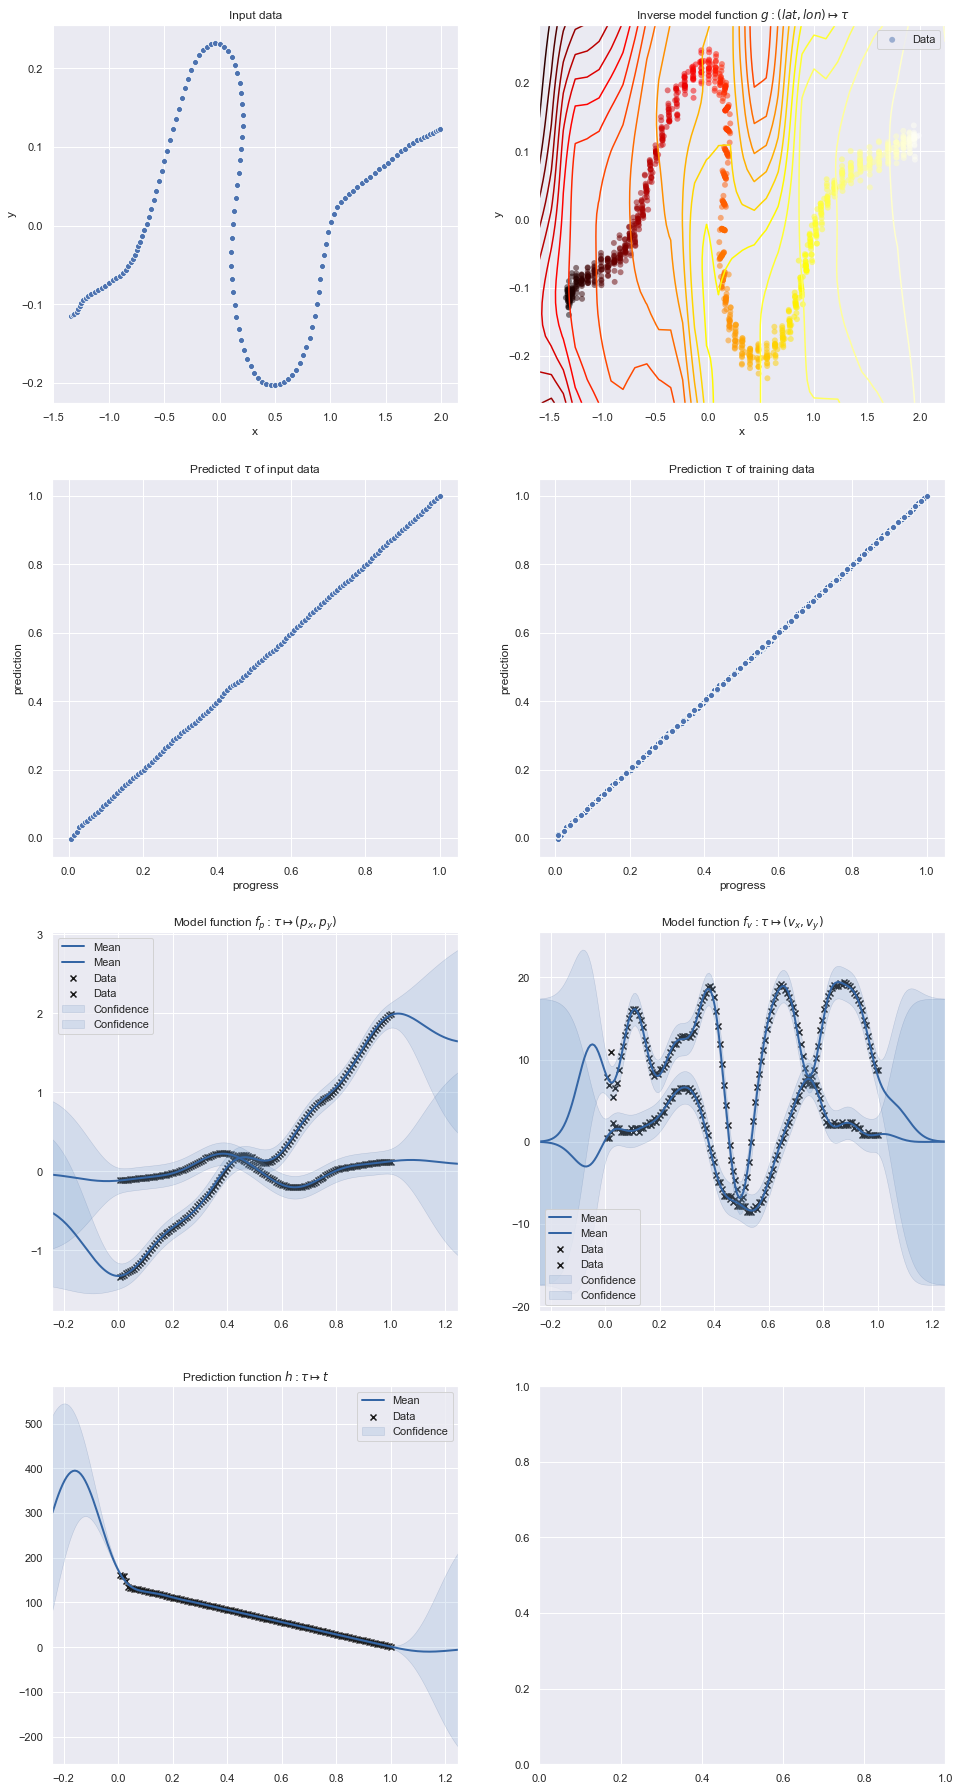

In [59]:
from math import sqrt, cos, sin, radians
from plotting import plot_grid
import seaborn as sns

%matplotlib inline
sns.set(style="darkgrid")

def learn_model(data: DataFrame, route_n: int, seg_n: int, f_p_codomain, f_v_codomain) -> TrajectoryModel:
    f_p_priors = FunctionModelPriors(None, None, None)
    f_v_priors = FunctionModelPriors(None, None, None)
    g_kern_ls_prior = None #gamma_prior(0.5, .002)
    g_kern_var_prior = None # gamma_prior(1, .5)
    g_kern_lik_prior = None
    g_priors = FunctionModelPriors(
        g_kern_ls_prior, 
        g_kern_var_prior, 
        g_kern_lik_prior)
    h_priors = FunctionModelPriors(None, None, None)

    n_restarts = 3
    D = data.shape[0]
    seg_9_f_p_lik = 0.005 
    seg_9_f_v_lik = 0.9
    fix_f_p_likelihood = seg_9_f_p_lik #None#0.001 #/ D
    fix_f_v_likelihood = seg_9_f_v_lik #None #0.5 #/ D
    n_augment_samples = 15
    normaliser = normaliser_for_seg(seg_n)
    augment_sigma = 6 / normaliser['sd']# meters
    augment_delta = 0.015
    #stop_compress_delta = 4 / normaliser['sd'] # meters

    return learn_trajectory_model(
        data, 
        route_n,
        seg_n,
        f_p_codomain,
        f_v_codomain, 
        f_p_codomain,
        f_p_priors=f_p_priors,
        f_v_priors=f_v_priors,
        g_priors=g_priors,
        h_priors=h_priors,
        n_restarts=n_restarts,
        fix_f_p_likelihood=fix_f_p_likelihood,
        fix_f_v_likelihood=fix_f_v_likelihood,
        n_augment_samples=n_augment_samples,
        augment_sigma=augment_sigma,
        augment_delta=augment_delta)

def plot_model(m: TrajectoryModel, data: DataFrame, f_p_codomain, f_v_codomain):
    n_rows = 4
    n_cols = 2
    fig_size = 8
    _, axs = plot_grid(n_rows, n_cols)

    # Input data
    sns.scatterplot(
        data=data, 
        x=f_p_codomain[0], 
        y=f_p_codomain[1], 
        ax=axs[0][0]
    )
    axs[0][0].set_title('Input data')

    # h for input data
    x = data[f_p_codomain].values
    mean, _  = predict(m.g, x)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': data['tau'].values
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][0]
    )
    axs[1][0].set_title(r'Predicted $\tau$ of input data')
    #axs[1][0].set_aspect('equal', 'datalim')

    # Training data
    plot_function(m.g, ax=axs[0][1])
    axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')
    axs[0][1].set_xlabel('x')
    axs[0][1].set_ylabel('y')
    
    # H for training data
    mean, _  = m.g.model.predict(m.g.model.X)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': m.g.model.Y.flatten()
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][1]
    )
    axs[1][1].set_title(r'Prediction $\tau$ of training data')

    # f_p
    m.f_p.model.plot(ax=axs[2][0])
    #plot_function(m.f_p, ax=axs[2][0])
    axs[2][0].set_title(r'Model function $f_p: \tau \mapsto (p_x, p_y)$')

    
    # f_v
    plot_function(m.f_v, ax=axs[2][1])
    axs[2][1].set_title(r'Model function $f_v: \tau \mapsto (v_x, v_y)$')

    # h
    plot_function(m.h, ax=axs[3][0])
    axs[3][0].set_title(r'Prediction function $h: \tau \mapsto t$')

np.random.seed(1)
route_n = 3
seg_n = 9
traj_n = traj_ns[0]
stop_compress_delta = 4 # meters
seg = pre_process(
    load_seg(traj_n, seg_n),
    stop_compress_delta
)
#print(seg)
f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
m = learn_model(
    seg, route_n, seg_n, 
    f_p_codomain, f_v_codomain
)
plot_model(
    m, seg, 
    f_p_codomain, 
    f_v_codomain
)
m.f_v.model

## Learn many models

In [40]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict
from functools import reduce

np.random.seed(1)

def learn(traj_n, seg_n):
    seg = pre_process(load_seg(traj_n, seg_n), stop_compress_delta)
    print(seg.shape)
    return learn_model(
        seg, route_n, seg_n, 
        f_p_codomain, f_v_codomain
    )

models = [
    learn(traj_n, seg_n) 
    for traj_n in traj_ns[:5]
]

with acquire_db_conn() as conn:
    for m in models:
        m_id = save_model(m, conn)

(138, 10)


Optimization restart 1/3, f = -408.0729726417304


Optimization restart 2/3, f = -408.07297266721747


Optimization restart 3/3, f = -408.07297267042173


Optimization restart 1/3, f = 386.6943721879622


Optimization restart 2/3, f = 386.69437218797697


Optimization restart 3/3, f = 386.6943721879647


Optimization restart 1/3, f = -5607.48870225399


Optimization restart 2/3, f = -5607.488702180173


Optimization restart 3/3, f = -5607.4887022547755


Optimization restart 1/3, f = 277.5057439011537


Optimization restart 2/3, f = 277.50574390099564


Optimization restart 3/3, f = 277.50574394721957
(116, 10)


Optimization restart 1/3, f = -333.8644370704277


Optimization restart 2/3, f = -333.8644370273336


Optimization restart 3/3, f = -333.86443700991236


Optimization restart 1/3, f = 394.00991433582794


Optimization restart 2/3, f = 394.00991433580845


Optimization restart 3/3, f = 394.0099143358354


Optimization restart 1/3, f = -5085.221525878882


Optimization restart 2/3, f = -5085.221529617451


Optimization restart 3/3, f = -5085.221529608911


Optimization restart 1/3, f = 250.09071578325006


Optimization restart 2/3, f = 250.09069310727187


Optimization restart 3/3, f = 250.09071578037543
(126, 10)


Optimization restart 1/3, f = -363.36536454703037


Optimization restart 2/3, f = -363.36536454676


Optimization restart 3/3, f = -363.3653645432502


Optimization restart 1/3, f = 416.50324320170364


Optimization restart 2/3, f = 416.503243214278


Optimization restart 3/3, f = 416.5032432017053


Optimization restart 1/3, f = -5246.702966970719


Optimization restart 2/3, f = -5246.702966997594


Optimization restart 3/3, f = -5246.702966970987


Optimization restart 1/3, f = 300.47426439570233


Optimization restart 2/3, f = 300.47426408716154


Optimization restart 3/3, f = 300.4613289629256
(133, 10)


Optimization restart 1/3, f = -388.1086271008852


Optimization restart 2/3, f = -388.1086270437645


Optimization restart 3/3, f = -388.1086271008871


Optimization restart 1/3, f = 425.89407170023856


Optimization restart 2/3, f = 1008.191498590578


Optimization restart 3/3, f = 425.8940716990628


Optimization restart 1/3, f = -4994.0585669753345


Optimization restart 2/3, f = -4994.058577167658


Optimization restart 3/3, f = -4994.058577165356


Optimization restart 1/3, f = 344.28086366438106


Optimization restart 2/3, f = 344.3050349103015


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 3/3, f = 344.2808636647376
(120, 10)


Optimization restart 1/3, f = -347.03922670852296


Optimization restart 2/3, f = -347.0392266357063


Optimization restart 3/3, f = -347.03922673248167


Optimization restart 1/3, f = 396.01738324966254


Optimization restart 2/3, f = 396.0173832519513


Optimization restart 3/3, f = 396.017383249703


Optimization restart 1/3, f = -4662.647025004071


Optimization restart 2/3, f = -4662.647024959728


Optimization restart 3/3, f = -4662.6470245237515


Optimization restart 1/3, f = 332.83007518460374


Optimization restart 2/3, f = 332.8300751819953


Optimization restart 3/3, f = 332.8390119168473


## Load many models

In [41]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from model import FunctionModel, TrajectoryModel, acquire_db_conn, load_models, compute_tau
from typing import List, Tuple
from numpy import ndarray
conn = acquire_db_conn()
with conn:
    models = load_models(route_n, seg_n, conn)

'loaded {} models'.format(len(models))

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


'loaded 5 models'

### Sanity Check

{'dataplot': [<matplotlib.collections.PathCollection at 0x120057e7048>,
 'gpmean': [[<matplotlib.lines.Line2D at 0x12019f9ae80>,
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x120178642e8>,
  <matplotlib.collections.PolyCollection at 0x1201a5cd518>]}

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


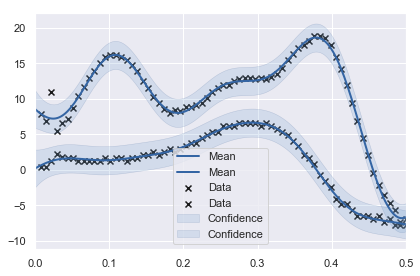

In [49]:
#plot_model(models[10])
models[test_traj_ix].f_v.model.plot(plot_limits=[0, fraction_observed])

# Make predictions

In [83]:
from functools import reduce
from scipy.stats import norm
from collections import defaultdict
from numpy.linalg import inv, det
import math

def arrival_time_prediction(models, f_codomain, data):
    
    def pred_and_loglik(model: TrajectoryModel, X_obs: ndarray):
        """Returns the model prediction for the remaining arrival time
        together with the summed log likelihood of the data for the provided model.
        """
        def loglik(x: ndarray, mu: ndarray, sigma: ndarray):
            return -0.5*((x-mu).T).dot(inv(sigma)).dot((x-mu)) \
                    -0.5*np.log(det(sigma))
        
        pos = X_obs[:,0:2]
        vel = X_obs[:,2:4]
        tau, _ = predict(model.g, pos)
        x_k_pos, sigma_pos_vec = predict(model.f_p, tau)
        x_k_vel, sigma_vel_vec = predict(model.f_v, tau)
        sigma_pos = np.diag(sigma_pos_vec.T[0])
        sigma_vel = np.diag(sigma_vel_vec.T[0])

        loglik_pos_x = loglik(pos[:,0], x_k_pos[:,0], sigma_pos)
        loglik_pos_y = loglik(pos[:,1], x_k_pos[:,1], sigma_pos)
        loglik_vel_x = loglik(vel[:,0], x_k_vel[:,0], sigma_vel)
        loglik_vel_y = loglik(vel[:,1], x_k_vel[:,1], sigma_vel) 
        loglik_sum = \
            loglik_pos_x + \
            loglik_pos_y + \
            loglik_vel_x + \
            loglik_vel_y
        
        # predict for the last point
        last_point = tau[-1].reshape(1, 1)
        prediction = predict(model.h, last_point)
        x = 0
        if math.isinf(loglik_sum) and x == 0:
            #plot_model(model, data, f_codomain[0:2], f_codomain[2:4])
            #sns.scatterplot(data=data, x='x', y='y')
            #x = 4
            #print('inf loglik', loglik_pos_x, loglik_pos_y, loglik_vel_x, loglik_vel_y)
            print(pos[:,0], x_k_pos[:,0], sigma_pos)
            print(pos[:,1], x_k_pos[:,1], sigma_pos)
            
        return prediction, loglik_sum
        
    def make_mixture(
        grid_res: int,
        grid_pad: int,
        preds: ndarray,
        logliks: List[float]) -> ndarray:
    
        def make_distribution(
            xx: ndarray, 
            pred: ndarray, 
            loglik: List[float]) -> ndarray:
            mean = pred[0]
            var = pred[1]
            return loglik*norm.pdf(xx, mean, np.sqrt(var))
        
        # Create grid that covers all components
        asc_preds = sorted(preds)
        smallest_pred_mean = float(asc_preds[0][0])
        smallest_pred_var = float(asc_preds[0][1])
        xmin = max(0, np.floor(smallest_pred_mean - smallest_pred_var*grid_pad))
        biggest_pred_mean = float(asc_preds[-1][0])
        biggest_pred_var = float(asc_preds[-1][1])
        xmax = np.ceil(biggest_pred_mean + biggest_pred_var*grid_pad)
        xx = np.linspace(xmin, xmax, (xmax-xmin)*grid_res)
            
        distributions = [
            make_distribution(xx, p, l) 
            for p, l in zip(preds, logliks) 
        ]
            
        return distributions, xx
        
    X_obs = data[f_codomain].values
    preds, logliks = zip(*[
        pred_and_loglik(m, X_obs)
        for m in models
    ])
    
    # Scale to avoid numerical errors due to small numbers
    c = 1/max(logliks)
    loglik_sum = sum(logliks)
    norm_liks = [np.exp(c*l - c*loglik_sum) for l in logliks]
    grid_res = 100
    grid_pad = 3
    return make_mixture(
        grid_res, grid_pad, preds, norm_liks
    )

models_to_use = models
# Test on previously seen segment
test_traj_ix = 3
test_traj_id = traj_ns[test_traj_ix]
print('predicting for', test_traj_id)
seg = load_seg(test_traj_id, seg_n) 
fraction_observed = 0.5
seg = pre_process(seg, stop_compress_delta, fraction_observed)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
distributions, xx = arrival_time_prediction(
    models_to_use, f_codomain, seg
)

predicting for 875


# Plot results

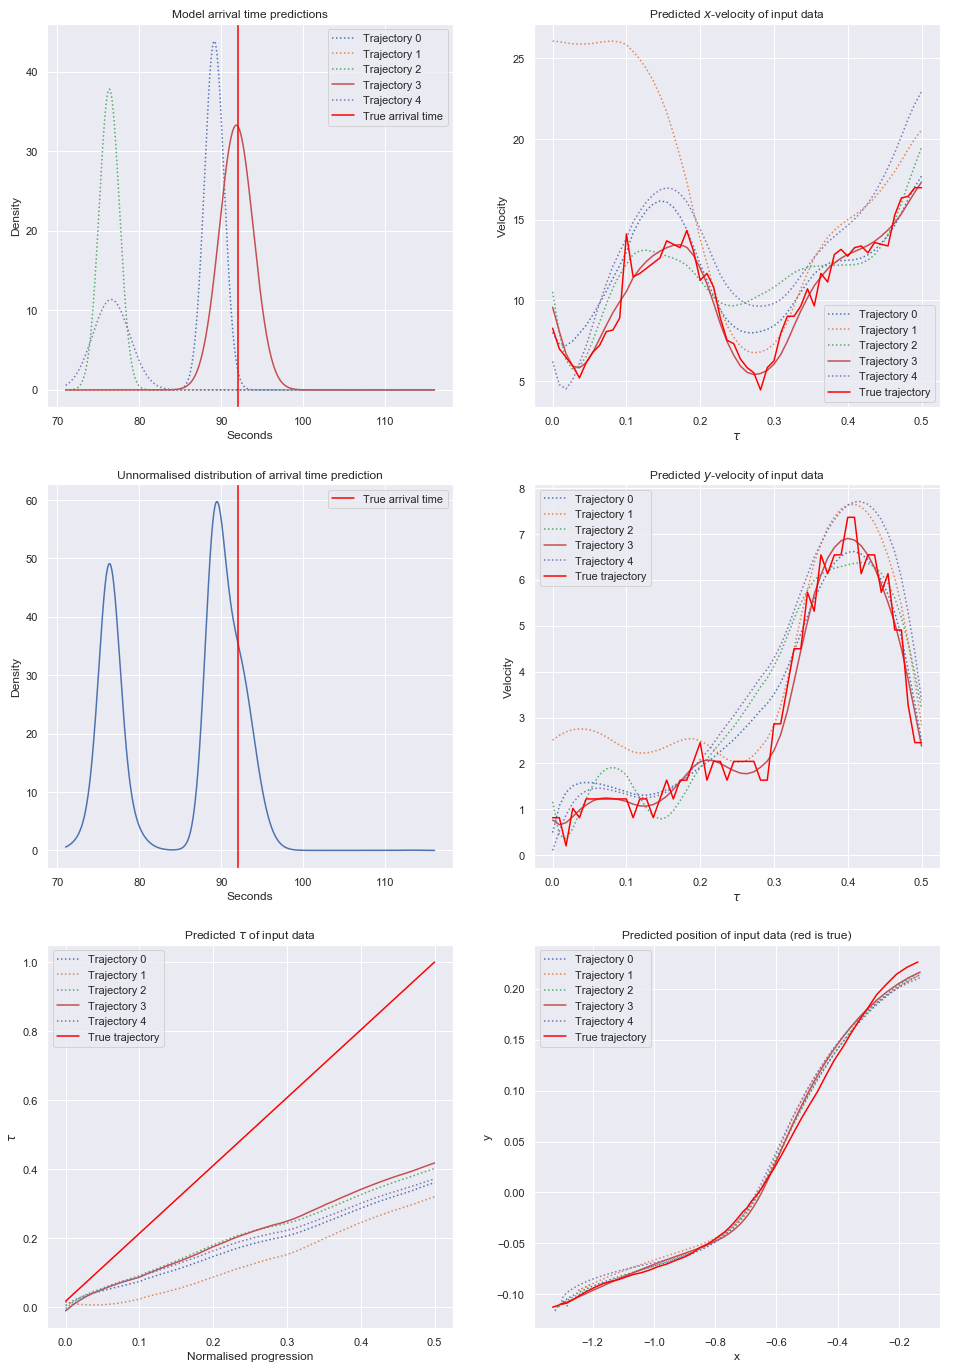

In [84]:
# Plotting results
from sklearn.preprocessing import StandardScaler
from plotting import plot_grid
from functools import reduce


def plot_mixture(ax, xx, distributions, time_left):
    for i, dist in enumerate(distributions):
        linestyle = '-' if i == test_traj_ix else ':'
        ax.plot(
            xx, dist.reshape(xx.shape), 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

    ax.set_title('Model arrival time predictions')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Density')
    ax.axvline(x=time_left, color='red', label='True arrival time')
    ax.legend()

    
def plot_mixture_sum(ax, xx, distribution, time_left):
    ax.plot(xx, distribution)
    ax.set_title('Unnormalised distribution of arrival time prediction')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Density')
    ax.axvline(x=time_left, color='red', label='True arrival time')
    ax.legend()
    
def plot_results(models, distributions, xx, seg, time_left, fraction_observed):
    n_rows = 3
    n_cols = 2
    _fig, axs = plot_grid(n_rows, n_cols)
    mixture_ax = axs[0][0]
    dist_sum_ax = axs[1][0]
    tau_pred_ax = axs[2][0]
    pos_pred_ax = axs[2][1]
    vel_x_pred_ax = axs[0][1]
    vel_y_pred_ax = axs[1][1]
    plot_mixture(mixture_ax, xx, distributions, time_left)
    dist_sum = reduce(np.add, distributions).reshape(xx.shape[0])
    plot_mixture_sum(dist_sum_ax, xx, dist_sum, time_left)
    
    xx = np.linspace(0, fraction_observed, seg.shape[0])
    for i, m in enumerate(models):
        linestyle = '-' if i == test_traj_ix else ':'
        tau, _  = predict(m.g, seg[f_codomain].values)
        
        # Plot tau
        tau_pred_ax.plot(
            xx, tau.T[0], 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot position
        pos, _ = predict(m.f_p, tau)
        pos_pred_ax.plot(
            pos[:,0], pos[:,1], 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )
        
        # Plot velocity x
        vel, _ = predict(m.f_v, tau)
        vel_x_pred_ax.plot(
            xx, vel[:,0],
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot velocity y
        vel_y_pred_ax.plot(
            xx, vel[:,1],
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

    tau_pred_ax.set_title(r'Predicted $\tau$ of input data')
    tau_pred_ax.set_xlabel('Normalised progression')
    tau_pred_ax.set_ylabel(r'$\tau$')
    tau_pred_ax.plot(
        xx, seg.tau,
        label='True trajectory',
        color='red'
    )
    tau_pred_ax.legend()
    
    pos_pred_ax.set_title(r'Predicted position of input data (red is true)')
    pos_pred_ax.set_xlabel('x')
    pos_pred_ax.set_ylabel('y')
    pos_pred_ax.plot(
        seg.x, seg.y,
        label='True trajectory',
        color='red'
    )
    pos_pred_ax.legend()
    
    vel_x_pred_ax.set_title(r'Predicted $x$-velocity of input data')
    vel_x_pred_ax.set_xlabel(r'$\tau$')
    vel_x_pred_ax.set_ylabel('Velocity')
    vel_x_pred_ax.plot(
        xx, seg.dx,
        label='True trajectory',
        color='red'
    )
    vel_x_pred_ax.legend()
    
    vel_y_pred_ax.set_title(r'Predicted $y$-velocity of input data')
    vel_y_pred_ax.set_xlabel(r'$\tau$')
    vel_y_pred_ax.set_ylabel('Velocity')
    vel_y_pred_ax.plot(
        xx, seg.dy,
        label='True trajectory',
        color='red'
    )
    vel_y_pred_ax.legend()
    
    plt.show()

plot_results(models_to_use, distributions, xx, seg, time_left, fraction_observed)

# Performance

In [87]:
from IPython.display import display, clear_output
import math

seg_sizes = [.2, .4, .6, .8]
mape = {s: defaultdict(dict) for s in seg_sizes}
mae =  {s: defaultdict(dict) for s in seg_sizes}
#segs = dict(tuple(data[data.seg = seg_n].groupby('seg')))

#fig, ax = plot_grid(1, 1)
test_segs = {
    traj_n: pre_process(load_seg(traj_n, seg_n), stop_compress_delta)
    for traj_n in traj_ns[:5]
}
for test_seg_n in test_segs.keys():
    for seg_size in seg_sizes:
        test_seg = test_segs[test_seg_n]
        r = int(test_seg.shape[0]*seg_size)
        seg = test_seg.head(r)
        time_left = seg.iloc[-1].time_left
        dists, xx = arrival_time_prediction(
            models_to_use, f_codomain, seg
        )
        dist = reduce(np.add, dists).reshape(xx.shape[0])
        #pred = np.sum(dist * xx) / np.sum(dist) # mean
        pred = xx[np.argmax(dist)] #mode
        if math.isnan(pred):
            print('dists are nan for ', seg_size, test_seg_n)
            
        abs_diff = np.abs(time_left-pred)
        mae[seg_size][test_seg_n] = abs_diff
        mape[seg_size][test_seg_n] = abs_diff / time_left
        #plot_mixture_sum(ax, xx, dist, time_left)
        #pred_ix = reduce(lambda i, w: i*w, enumerate(dist)) / np.sum(dist)
        #print(pred_ix)
    #clear_output()
    print('Done seg', test_seg_n)
    
avg_mae = [np.sum(list(mae[s].values())) / len(mae[s].values()) for s in seg_sizes]
avg_mape = [np.sum(list(mape[s].values())) / len(mape[s].values()) for s in seg_sizes]

# loglik_pos_x, loglik_pos_y are inf

Done seg 147
Done seg 299
Done seg 392
Done seg 875
Done seg 1278


MAE:  [4.668378576179014, 0.8175929568361937, 0.727892836104148, 1.3076619776516758]
MAPE:  [0.038996915270303925, 0.009219843444616932, 0.01329942392903701, 0.04588643693862945]


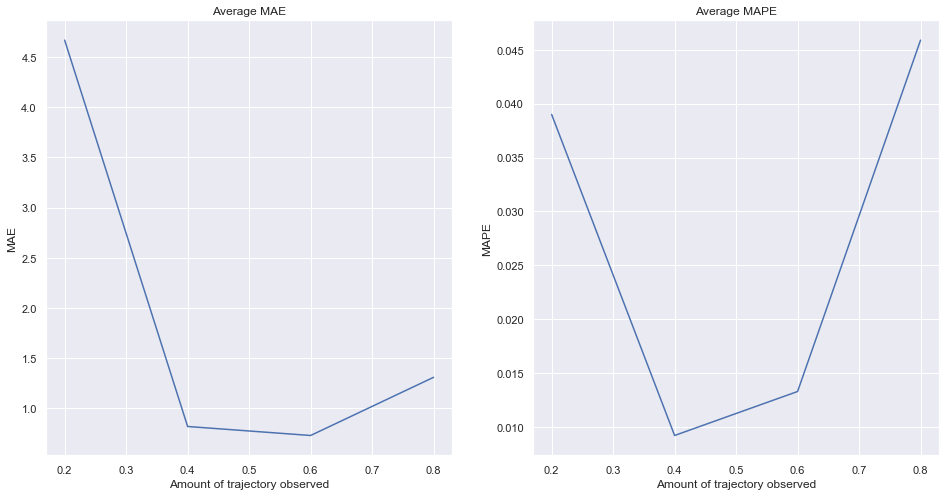

In [88]:
fig, ax = plot_grid(1, 2)
ax[0].plot(seg_sizes, avg_mae)
ax[0].set_title('Average MAE')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Amount of trajectory observed')

ax[1].set_title('Average MAPE')
ax[1].set_ylabel('MAPE')
ax[1].set_xlabel('Amount of trajectory observed')
ax[1].plot(seg_sizes, avg_mape)

print('MAE: ', avg_mae)
print('MAPE: ', avg_mape)